# Description
This nodebook handles the data pre-processing pipeline from 3 chosen Datasets Quotebank, WikiData and allSides Media Bias Rating to the final data used for network plotting and network analysis.

The final data is a json structure containing all political mentions in Quotebank data from 2015 to 2020. Here we define the political mentions as quotes including the names or aliases of politicians, which are spoken by US politicians. The final data is available in the data folder and all intermediate steps and data are stored on a [Google Drive](https://drive.google.com/drive/folders/1gTloM4zpa3v1pq2SC2avb1NwPTfu5v_u) to EPFL accounts.

The final data is structured in a way that each row includes:
 - Unique ID of political mention
 - Speaker politician (American)
 - Mentioned politician (world-wide or US-wide, one or more, can include self)
 - Sentiment of mention (Value between 0 and 1)
 - Topic of mention (1 of 8 topics inferred from Latent Dirichlet Allocation)
 - Bias of mention (Value between -1 and 1, inferred from Media source of mentions)

In order to get the final data from the chosen raw datasets, the pre-processing pipeline has to take place:
1. Filter out and interpret all alive politicians in wikidata dump and build a politician catalogue. 
2. Filter all political mentions in Quotebank from 2015 to 2020.
3. Perform Latent Dirichlet Allocation (LDA) topic clustering on the contents of mentions, assign topic to each mention.
4. Perform Sentiment Analysis on the contents of mentions using pretrained lexicon, assign the sentiment score to each mention.
5. Look up the domain of quotation sources in allSides Media Bias Rating dataset, assign a bias score indicating the bias of media reporting the mention (-1 for extreme left, 0 for neutral, 1 for extreme right).

# Required packages
 - [qwikidata](https://qwikidata.readthedocs.io/en/stable/)
 - [json](https://docs.python.org/3/library/json.html)
 - [bz2](https://docs.python.org/3/library/bz2.html)
 - [pandas](https://pandas.pydata.org/)
 - [cv2](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html)
 - [gensim](https://radimrehurek.com/gensim/)
 - [nltk](https://www.nltk.org/)
 - [spaCy](https://spacy.io/)

 
# Required data
 - [Wikidata dump](https://dumps.wikimedia.org/wikidatawiki/entities/)
 - [Quotebank data_dump](https://zenodo.org/record/4277311#.YaKLoWDMJm8)
 - [Partisan Audience Bias Scores](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/QAN5VX)


4. Dumped the dataframe into 2 jsons. The first json contains the compact information for each political quotation that appeared in the Quotebank dataset, with possible multiple values of mentioned names(mentioned QIDs), domains of source and a total count of occurences of this quotation, which is more handy for analysis. The second json is a flattened version of the first file, in which a record with m mentions and n sources are exploded and flattened into m*n records, which is more handy for plotting.

In [1]:
import pandas as pd
import numpy as np
import bz2
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

## Step 1: Politician catalogue preprocessing from Wikidata
In this part we filter out and interpret all alive politicians in wikidata dump and build a politician catalogue. The catalogue would help to pick out the political mentions in the next step and determine mentioning and mentioned people.
The step 1 performed as follows:
1. Go through entities of full wikidata dump in stream mode and filter out alive politicians.
2. Dump names, aliases and other selected properties including country of citizenship, gender, religion, party (with start and end date) and positions held (with start and end date) into a politician catalogue. For US politicians, also dump the compressed figures if they have one on wiki (optional). For politicians that are missing selected properties, regard the entity as corrupted and discard the politician record.
3. Interpret the dumped politician properties from QIDs to meaningful notions with offline QID dictionary(provided by ADA staffs) lookup. In case of missing QIDs in offline dictionary, make a query to wikidata API to ask about the interpertation and extend the offline catalogue. In case of missing QIDs in online dictionary, regard the entity as corrupted and discard the politician record.

In [2]:
#import functions for Step 1
from PoliticianFilter import dump_politicians,dump_figures
from QID_interpretation import interpret_qids, single_interpret, list_interpret, listlist_interpret
from QuotesFilterSpeaker import quotes_filter_speaker
from QuotesFilterMentions import generate_patterns, filter_mentions, parse_mentions
#Constants for Step 1

#wikidata
#path to input of full wiki data dump (80G compressed file) 
WIKI_DATA_FULL = 'data/latest-all.json.bz2' 
#path to input of local QID dictionary
Q_catalogue = 'data/wikidata_labels_descriptions_quotebank.csv.bz2' 

#path to output file of filtered wiki data dump with only alive politician entities
WIKI_DATA_FILTERED = 'data/filtered_politician_v2.json.bz2' 
#path to output folder to store dumped politician images #available on Google Drive
WIKI_DATA_IMAGE = 'data/img' 
#path to output file of extended QID dictionary
Q_catalogue_new = 'data/wikidata_labels_descriptions_quotebank_expanded.csv.bz2'
#path to output log of missing QIDs log 
WIKI_DATA_FILTERED_MISSINGQ = 'data/filtered_politician_missingqids_v3.json.bz2' 
#path to output file of filtered alive politician entities with interpreted QIDs
WIKI_DATA_FILTERED_LABELED = 'data/filtered_politician_labeled_v3.json.bz2' 

First we build politician catalogue from wikidata.
We dump alive politicians with selected properties in to politician catalogue.

In [18]:
'''
dump_politicians
input: wikidata dump
output: politician entities from wikidata dump
The function dump_politicians takes as input full wikidata json dump from WIKI_DATA_FULL
and dumps politician entity to the WIKI_DATA_FILTERED
if verbose = True, print all debug information when a corrupted entity is detected (qid, missing value)
'''
dump_politicians(WikidataJsonDump(WIKI_DATA_FULL),WIKI_DATA_FILTERED,verbose = False)
politician_catalogue = pd.read_json(WIKI_DATA_FILTERED, lines=True, compression='bz2')
print(f'Filtered {len(politician_catalogue)} politician records in total')

Filtered 269337 politician records in total


We pick out US politicians from politician catalogue and dump the figures from the wiki page if they have one.

In [4]:
# read the dumped politician catalogue in last cell and filter US politician with country of citizen ship is USA
US_politician_catalogue = politician_catalogue[politician_catalogue['nationality']=='Q30']
# get the qid list of US politician to request images
US_qid = US_politician_catalogue['qid'].tolist()
'''
dump_figures
input: US politician QID list
output: US politician figures if available
The function dump_figures takes as input the qid list of US politicians
make HTTP request to wikidata API and download first image of the politician into folder WIKI_DATA_IMAGE
the images are scaled within 300x400 pixels to reduce the disk consumption
'''
dump_figures(US_qid,WIKI_DATA_IMAGE,verbose=False)

We interpret the politician catalogue with offline and online QID dictionary. Also, we interpret the states where US politicians get the political position.

In [7]:
'''
interpret_qids
input: dumped politician catalogue
output: interpreted politician catalogue with notations replacing QIDs
The function interpret_qids takes as input the raw filtered politician entities "WIKI_DATA_FILTERED"
and looked up the QID meanings in offline QID dictionary "Q_catalogue"
If the look-up fails, the function makes online query to the wikidata API
The query result is used to extend the offline QID dictionary "Q_catalogue_expanded"
If the query fails again, the politician identity is considered corrupted and removed. The QIDs are saved into a log file "WIKI_DATA_FILTERED_MISSINGQ".
When interpreting the positions held by the politician, the function also appends a column to the politician catalogue
indicating the most probable state where the politician gets its position.
If verbose is True, print all unknown QIDs in off-line dictionary and print their online interpretations at runtime.
'''
Q_catalogue_expanded = interpret_qids(WIKI_DATA_FILTERED, Q_catalogue, WIKI_DATA_FILTERED_LABELED, WIKI_DATA_FILTERED_MISSINGQ, single_interpret, list_interpret, listlist_interpret, verbose = False)
#update qid catalogue
with open(Q_catalogue_new, 'wb') as write_buf:
    Q_catalogue_expanded.to_csv(path_or_buf=write_buf, compression='bz2', encoding= 'utf-8')

## Step2:  Political mentions preprocessing from Quotebank
In this part we go through Quotebank data and fliter out political mentions by US that either contain other US politicians or leader of other country in the world.
The Step 2 performed as follows:
1. Go through Quotebank data with the politican catalogue to fliter out quotes said by US politicians.
2. Generate the regular expression containing all politician aliases/names for US politicians/world country leaders.
3. Use the regular expression to fliter out all quotes that are political mentions including names/aliases of US politicians/world country leaders.
4. Map the matching alias back to the unique QID and most common name of politician and append the data as two new columns to political mentions.
5. Interpret the mention source urls into domains for media bias calibration in Step 5.

In [3]:
#import functions for Step 2
from QuotesFilterSpeaker import quotes_filter_speaker
from QuotesFilterMentions import generate_patterns, filter_mentions, parse_mentions
#Constants for Step 2

#quotebank
#path of input folder containing the quotebank quotes from 2015 to 2020
quotebank_dir ='data/quote_bank_raw' 
#path to output file of political mentions by US politicians #available on Google Drive
QUOTES_BY_US = 'data/quotes_by_USA.json.bz2' 
#path to output file of political mentions mentioning at least 1 US politician
QUOTES_MENTIONS_US = 'data/quotes_mentions_USA.json.bz2' 
#path to output file of political mentions mentioning at least 1 US politician in compact format
QUOTES_MENTIONS_US_PARSED_COMPACT = '/data/quotes_mentions_USA_compact.json.bz2'
#path to output file of political mentions mentioning at least 1 US politician in expanded format
QUOTES_MENTIONS_US_PARSED_FLAT = '/data/quotes_mentions_USA_flattened.json.bz2'
#path to output file of political mentions mentioning at least 1 non-US politician
QUOTES_MENTIONS_WORLD = '/data/quotes_mentions_world.json.bz2'
#path to output file of political mentions mentioning at least 1 non-US politician in compact format
QUOTES_MENTIONS_WORLD_PARSED_COMPACT = '/data/quotes_mentions_world_compact.json.bz2'
#path to output file of political mentions mentioning at least 1 non-US politician in expanded format
QUOTES_MENTIONS_WORLD_PARSED_FLAT = '/data/quotes_mentions_world_flattened.json.bz2'

We filtered quotes from Quotebank data. We go through all quotes in Quotebank dataset and pick out the quotes that are spoken by US politicians.

In [ ]:
'''
quotes_filter_speaker
input: quotebank compressed data file from 2015 to 2020
output: all quotes said by US politicians
The function quotes_filter_speaker takes as input the directory storing all Quotebank data,
and filter out all quotes spoken by US politicians by checking if speaker qid appears in politician catalogue
'''
quotes_filter_speaker(quotebank_dir, QUOTES_BY_US,WIKI_DATA_FILTERED)

We generated the patterns of all US politicians and world country leaders used to check the quote contents.

In [1]:
'''
generate_patterns
input: politician catalogue, a bool value to filter US or non-US pattern
output: The regular expression of all US/non-US politician names/aliases patterns
        A look up table to map politician from matching of patterns
If US is true, the function generate_patterns take as input the politician catalogue generated in wikidata filtering,
and output a regular expression of all names and aliases of US politician.
If US is false,  the function does online query to the head of states and head of governments of all countries to wiki database,
and output a regular expression of all names and aliases of country leaders.
The function also handles names with special symbols and corrupted names automatically.
'''
pattern_US, pattern_US_flat = generate_patterns(WIKI_DATA_FILTERED_LABELED,US=True)
pattern_world, pattern_world_flat = generate_patterns(WIKI_DATA_FILTERED_LABELED,US=False)

We used the generated pattern to filter the quotes to find political mentions.

In [32]:
'''
filter_mentions
input: quotes said by US politicians, pattern to look for in the quote contents
output: filtered quotes which are political mentions containing the input pattern.
The function filter_mentions take as input all quotes said by US politicians and an input pattern.
The function uses the name pattern to search for all quotes with contents matching the pattern to filter out political mentions.
'''
filter_mentions(QUOTES_BY_US,pattern_US,QUOTES_MENTIONS_US,verbose=False)
filter_mentions(QUOTES_BY_US,pattern_world,QUOTES_MENTIONS_WORLD,verbose=False)

We parsed the mentioned politician in political mentions as QID and name and appended them as new columns.

In [ ]:
'''
parse_mentions
input: political mentions by US politicians, pattern to look for in the quote contents
output: filtered political mentions with name, QID of mentioned politicians.
The function parse_mentions takes as input the political mentions from last step, the name pattern and the lookup table.
The function uses the name pattern and the lookup table(second output of generate_patterns) to find out who is exactly mentioned in the political mentions.
The unique QIDs and most commonly used names of mentioned politicians are appended as an extra column to the end of political mentions.
The output of the function is either compact or flat version.
Also, the quote source urls are also interpreted into main-domain and top-level-domain for the calibration of quotes.
The compact version has the same rows as the political mention inputs,
while the flat version unfolds mentions that include multiple mentions or multiple sources.
'''
parse_mentions(QUOTES_MENTIONS_US, pattern_US, pattern_US_flat, QUOTES_MENTIONS_US_PARSED_COMPACT, QUOTES_MENTIONS_US_PARSED_FLAT, verbose = False)
parse_mentions(QUOTES_MENTIONS_WORLD, pattern_world, pattern_world_flat, QUOTES_MENTIONS_WORLD_PARSED_COMPACT, QUOTES_MENTIONS_WORLD_PARSED_FLAT, verbose = False, US=False)

## Part 3: Latent Dirichlet Allocation (LDA)
In this part we perform Latent Dirichlet Allocation (LDA) on the political mentions within US for topic extraction. The procedure is as follows:

1. Load data `QUOTES_MENTIONS_US_PARSED_COMPACT` and save quotations by years as seperate documents. For each year, take 60000 sentences as training data.
2. Preprocess data using customized spacy nlp pipeline including tokenizer, parser, removing stopwords. Finally, the politician names are removed.
3. Turn the processed corpus into bag of words (bow) representation.
4. Train the LDA model given the number of desierd topics.
5. Load trained model and assign the topic index and probability using the trained model. 

Note that training process (step 1 to 4) is scripted in `src/util_ml.py`. For the model is loaded directly.

## Part 4: Sentiment Analysis
In this part we perform Sentiment Analysis on the political mentions inter US to cluster the mention topics.

Here nltk [vader sentiment analyzer](https://ojs.aaai.org/index.php/ICWSM/article/view/14550)* is used as is because it is a rule-based model for general purpose sentiment analysis and specifically tuned for microblog type contents so it is suitable to handle quotations. 

\* C. Hutto and E. Gilbert, “VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text”, ICWSM, vol. 8, no. 1, pp. 216-225, May 2014.

In [ ]:
QUOTES_MENTIONS_US_NLP = "../data/quotes_mentions_USA_ML.json.bz2"

In [ ]:
from util_ml import save_sentiment_topics

save_sentiment_topics(QUOTES_MENTIONS_US_NLP ,QUOTES_MENTIONS_US_PARSED_COMPACT)

## Part 5: Media bias
The medias are expected to selectively report news containing political mentions. In this part we utilize the Partisan Audience Bias Scores dataset to grade the bias of political mentions reported by different media for visualisation in plotting. 
The Step 5 is performed as follows:
1. Read data from last step.
2. Parse urls of the quotations to match the format in media bias dataset.
3. Match the urls with the dataset domains, if a quotation is cited by different sources, then the mean score is taken. If none of the sources is found in the dataset, then nan is filled.

In [ ]:
QUOTES_MENTIONS_US_NLP_BIAS = "../data/quotes_mentions_USA_ML_bias.json.bz2"
save_bias(QUOTES_MENTIONS_US_NLP_BIAS, QUOTES_MENTIONS_US_NLP)

In [ ]:
import seaborn as sns
df = pd.read_json(QUOTES_MENTIONS_US_NLP_BIAS, lines=True, compression='bz2' )
ratio = len(df[df['source_bias'].isna()]) / len(df)
print("{:.2%} sources not found in bias database".format(ratio))
sns.histplot(df['source_bias'])

## FinalData

As a result we shown the final data for the politician catalogue and political mentions. The data will be used for the network visualisation and interactive control of displaying network or filter properties of nodes.

In [47]:
#all politician catalogues
df=pd.read_json('data/filtered_politician_labeled_v3.json.bz2',lines=True,compression='bz2')
print(len(df))
df.head(5)

269337


,qid,name,gender,nationality,aliases,parties,positions held,religion,us_congress_id,candidacy_election
0,Q207,George W. Bush,male,United States of America,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[Republican Party],"[[Governor of Texas, [+1995-01-17T00:00:00Z]],...",United Methodist Church,,"[2000 United States presidential election, 200..."
1,Q946,Donald Tusk,male,Poland,[Donald Franciszek Tusk],"[Civic Platform, European People's Party]","[[Prime Minister of Poland, [+2007-11-16T00:00...",Catholic Church,,[2005 Polish presidential election]
2,Q1058,Narendra Modi,male,India,"[Modi, Narendra Bhai, Narendra Damodardas Modi...",[Bharatiya Janata Party],"[[Chief Minister of Gujarat, [+2001-10-07T00:0...",Hinduism,,[2014 Indian general election in Vadodara Lok ...
3,Q1253,Ban Ki-moon,male,South Korea,"[Ban Kimoon, Ban Ki Moon]",[independent politician],"[[United Nations Secretary-General, [+2007-01-...",Confucianism,,[]
4,Q3996,V. P. Kalairajan,male,India,[],[All India Anna Dravida Munnetra Kazhagam],[[Member of the Tamil Nadu Legislative Assembl...,,,[]


In [10]:
#US politician catalogues
df=pd.read_json('data/filtered_politician_labeled_US_v3.json.bz2',lines=True,compression='bz2')
print(len(df))
df.head(5)

25760


,qid,name,gender,nationality,aliases,parties,positions held,religion,us_congress_id,candidacy_election,State
0,Q207,George W. Bush,male,Q30,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[Republican Party],"[[Governor of Texas, [+1995-01-17T00:00:00Z]],...",Q329646,,"[2000 United States presidential election, 200...",Texas
1,Q4496,Mitt Romney,male,Q30,"[Willard Mitt Romney, Pierre Delecto]",[Republican Party],"[[Governor of Massachusetts, [+2003-01-02T00:0...",Q42504,R000615,"[2012 Republican Party presidential primaries,...",Massachusetts
2,Q11124,Stephen Breyer,male,Q30,[Stephen Gerald Breyer],[Democratic Party],[[Associate Justice of the Supreme Court of th...,Q9268,,[],None
3,Q11674,David Paterson,male,Q30,[David Alexander Paterson],[Democratic Party],"[[Governor of New York, [+2008-03-17T00:00:00Z...",,,[],New York
4,Q22201,Jim DeMint,male,Q30,"[James Warren ""Jim"" DeMint, James Warren DeMint]",[Republican Party],"[[United States representative, []], [United S...",Q178169,D000595,[],None


In [15]:
#political mentions
df=pd.read_json('data/quotes_mentions_USA_ML_bias.json.bz2',lines=True,compression='bz2')
print(len(df))
df.drop(columns=['quoteID','quotation','phase','urls','topic_index','source_bias']).head()

450436


,speaker,qids,date,numOccurrences,mentions,mentions_qids,topic_scores,sentiment
0,Bernie Sanders,Q359442,2015-10-25 14:12:35,1,[Bill Clinton],[Q1124],0.818588,-0.4822
1,John Boehner,Q11702,2015-08-07 12:52:52,1,[Barack Obama],[Q76],0.774811,0.0000
2,Hillary Clinton,Q6294,2015-10-01 14:56:48,2,[Bill Clinton],[Q1124],0.368826,-0.2732
3,Phil Bryant,Q887898,2015-11-17 20:03:05,1,[John Kerry],[Q22316],0.774721,0.0258
4,John Cornyn,Q719568,2015-02-14 21:01:51,2,[Barack Obama],[Q76],0.389230,-0.1280


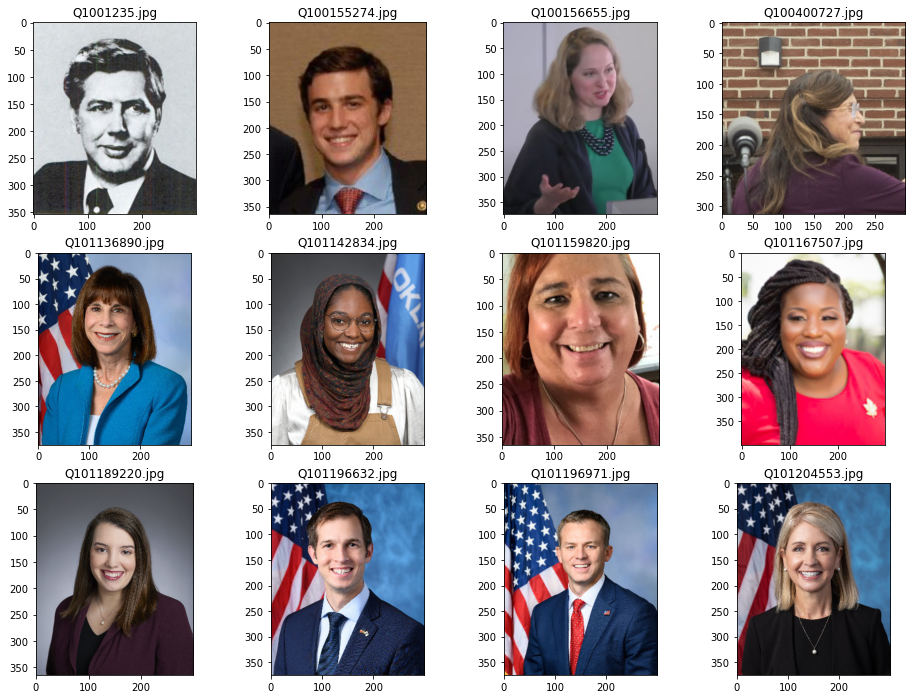

In [45]:
#politician images
directory=os.listdir('../data/img') #need to download img folder from Google Drive to make this work
plt.figure(figsize=(16, 12))
for i, file in enumerate(directory):
    if i == 12:
        break
    img=plt.imread('../data/img/'+file)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(str(file))